In [1]:
#!pip3 install imblearn
#!pip3 install opencv-python

In [31]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob


# 1. READ-IN DATA TO DF

In [3]:
df = pd.read_csv("labels-map-proj_v3_2.txt", sep=" ", header=None, names=["image", "label"])

# filter all images that end with fv, brt, r90, r180, r270, and fh
df = df[~df["image"].str.contains("fv|brt|r90|r180|r270|fh")]
print(df.shape)
df.head(5)

(10815, 2)


,image,label
0,ESP_013049_0950_RED-0067.jpg,7
7,ESP_019697_2020_RED-0024.jpg,1
14,ESP_015962_1695_RED-0016.jpg,1
21,ESP_013049_0950_RED-0118.jpg,7
28,ESP_015962_1695_RED-0017.jpg,1


In [4]:
df["label"].value_counts()

label
0    8802
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

# 2. DELETE 8k RANDOM IMAGES & SHUFFLE

In [5]:
# delte 7802 random images from the category with label 0
df_us = df.drop(df[df["label"] == 0].sample(7702, random_state=1).index)
df_us["label"].value_counts()

label
0    1100
1     794
6     298
3     267
4     250
2     166
7     164
5      74
Name: count, dtype: int64

In [6]:
# shuffle the dataframe
df_us = df_us.sample(frac=1, random_state=1).reset_index(drop=True)
df_us.head(5)

,image,label
0,ESP_018720_2655_RED-0035.jpg,2
1,ESP_046991_0950_RED-0024.jpg,7
2,ESP_039350_1915_RED-0186.jpg,1
3,ESP_014156_1865_RED-0023.jpg,3
4,ESP_013049_0950_RED-0088.jpg,7


# 3. READ-IN TO PIXELS

In [7]:
def load_images_labels_from_df(df, folder):
    images = []
    labels = []
    for i in range(len(df)):
        img = cv2.imread(folder+"/"+df.iloc[i][0], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            labels.append(df.iloc[i][1])
    return np.array(images), np.array(labels)

In [8]:
X, y = load_images_labels_from_df(df_us, "map-proj-v3_2")
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)
print(X.shape[0])

[0 1 2 3 4 5 6 7] [1100  794  166  267  250   74  298  164]
3113


# 4. NORMALIZE DATA TO 0-1

In [9]:
X_norm = X / 255.0
print(X_norm.min())
print(X_norm.max())

0.0
1.0


# 5. TRAIN-TEST SPLIT

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2179, 227, 227) (934, 227, 227) (2179,) (934,)


In [11]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train, return_counts=True)[1]/y_train.shape[0])

print(np.unique(y_test, return_counts=True))
print(np.unique(y_test, return_counts=True)[1]/y_test.shape[0])

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([774, 539, 115, 176, 183,  52, 222, 118]))
[0.35520881 0.24736117 0.0527765  0.080771   0.08398348 0.02386416
 0.1018816  0.05415328]
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([326, 255,  51,  91,  67,  22,  76,  46]))
[0.3490364  0.27301927 0.05460385 0.09743041 0.07173448 0.0235546
 0.08137045 0.04925054]


# 6. IMBALANCE HANDLING

## 6.0 Flatten Images

In [13]:
X_reshaped = X_train.flatten().reshape(X_train.shape[0], 51529)
print(X_train.shape)
print(X_reshaped.shape)

(2179, 227, 227)
(2179, 51529)


## 6.1 ADASYN

In [14]:
adasyn = ADASYN(sampling_strategy="not majority", random_state=1)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_reshaped, y_train) # type: ignore

## 6.2 OVERSAMPLING

In [58]:
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=3)
X_resampled, y_resampled = oversampler.fit_resample(X_reshaped, y_train) # type: ignore

In [76]:
l1 = pd.DataFrame(X_resampled[np.where(y_resampled == 1)[0]])
print(f"Number of duplicates for the first label after oversampling: {l1.duplicated().sum()}")
all_l = pd.DataFrame(X_resampled)
print(f"Number of duplicates for all labels after oversampling: {all_l.duplicated().sum()}")

Number of duplicates for the first label after oversampling: 235
Number of duplicates for all labels after oversampling: 4013


In [77]:
unique, counts = np.unique(y_train, return_counts=True)
unique_a, counts_a = np.unique(y_train_adasyn, return_counts=True)
unique_b, counts_b = np.unique(y_resampled, return_counts=True)
print(X_train_adasyn.shape)
print(unique, counts)
print(unique_a, counts_a)
print(unique_b, counts_b)

(6226, 51529)
[0 1 2 3 4 5 6 7] [774 539 115 176 183  52 222 118]
[0 1 2 3 4 5 6 7] [774 824 763 772 789 762 760 782]
[0 1 2 3 4 5 6 7] [774 774 774 774 774 774 774 774]


In [78]:
X_t_A = X_train_adasyn.reshape(X_train_adasyn.shape[0], 227, 227) # type: ignore
y_t_A = y_train_adasyn

X_t_O = X_resampled.reshape(X_resampled.shape[0], 227, 227) # type: ignore
y_t_O = y_resampled

print(f"Shape of training instances generated by ADASYN: \n{X_t_A.shape}, correspoding y: {y_t_A.shape}")
print(f"Shape of training instances generated by RandomOverSampler: \n{X_t_O.shape}, correspoding y: {y_t_O.shape}")

Shape of training instances generated by ADASYN: 
(6226, 227, 227), correspoding y: (6226,)
Shape of training instances generated by RandomOverSampler: 
(6192, 227, 227), correspoding y: (6192,)


# 6. AUGMENTATION
1. Rotate 90
2. Rotate 180
3. Rotate 270
4. Flip Horizontally
5. Flip Vertically
6. Zoom
7. (Random Brightness)?

In [212]:
def zoom_at(img, zoom=1.0):
    h, w, = [zoom * i for i in img.shape]
    cx, cy = w/2, h/2
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
              int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

# function that rotates an image by 90, 180, and 270 degrees and flips it horizontally and vertically and zooms in on the image and adjusts the brightness randomly
def augment_image_zoom(img):
    img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) # rotate the image by 90 degrees clockwise
    img_180 = cv2.rotate(img, cv2.ROTATE_180) # rotate the image by 180 degrees
    img_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE) # rotate the image by 270 degrees clockwise
    img_fh = cv2.flip(img, 1) # flip the image horizontally
    img_fv = cv2.flip(img, 0) # flip the image vertically
    img_zoom = zoom_at(img, 1.2) # zoom in on the image
    #img_brt = cv2.convertScaleAbs(img, beta=0.8) # adjust the brightness randomly
    return np.array([img, img_90, img_180, img_270, img_fh, img_fv, img_zoom])

# function that creates a copy of that image and adds it to the X_t_A array
def create_augmented_train(X, y):
    X_new = np.empty((0, 227, 227))
    y_new = np.empty((0))
    for i in range(len(X)):
        X_new = np.concatenate((X_new, augment_image_zoom(X[i])))
        for _ in range(len(augment_image_zoom(X[i]))):
            y_new = np.append(y_new, y[i])
        print(f"Image {i} done")
    return X_new, y_new

In [265]:
def create_augmented_train(X, y):
    out_x = []
    out_y = []
    for i in range(len(X)):
        out_x.append(augment_image_zoom(X[i]))
        out_y.append(np.array([y[i]] * 7))
        print(f"Image {i} done")
    return out_x, out_y

a, b = create_augmented_train(X_t_A[:5], y_t_A[:5])
print(len(a), len(b))
for i in range(len(a)):
    print(a[i].shape)
    print(b[i])
for j in range(len(X_t_A[:5])):
    print(X_t_A[j].shape)
    print(y_t_A[j])

Image 0 done
Image 1 done
Image 2 done
Image 3 done
Image 4 done
5 5
(7, 227, 227)
[1 1 1 1 1 1 1]
(7, 227, 227)
[7 7 7 7 7 7 7]
(7, 227, 227)
[1 1 1 1 1 1 1]
(7, 227, 227)
[1 1 1 1 1 1 1]
(7, 227, 227)
[0 0 0 0 0 0 0]
(227, 227)
1
(227, 227)
7
(227, 227)
1
(227, 227)
1
(227, 227)
0


In [274]:
# vstack all arrays in a list but retain shape
np.vsta

(7945, 227)
5
(7, 227, 227)


In [248]:
# create a function that splits the data into parts of 50 observations
def split_data(X, y, n):
    X_split = np.array_split(X, n)
    y_split = np.array_split(y, n)
    return np.array(X_split), np.array(y_split)

a, b = split_data(X_t_A, y_t_A, 50)

sumx = 0
for i in a:
    sumx += i.shape[0]
print(sumx)

sumy = 0
for j in b:
    sumy += j.shape[0]
print(sumy)

print(len(X_t_A))
print(len(y_t_A))

6226
6226
6226
6226


/var/folders/6s/hmlg0x1n07x_fl9blny_v37r0000gn/T/ipykernel_15231/655607824.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_split), np.array(y_split)


In [249]:
result = []
for i in range(len(a)):
    print(f"Working on subset {i} of {len(a)}")
    print(a[i].shape)
    print(b[i].shape)
    result.append(create_augmented_train(a[i], b[i]))

Working on subset 0 of 50
(125, 227, 227)
(125,)
Image 0 done
Image 1 done
Image 2 done
Image 3 done
Image 4 done
Image 5 done
Image 6 done
Image 7 done
Image 8 done
Image 9 done
Image 10 done
Image 11 done
Image 12 done
Image 13 done
Image 14 done
Image 15 done
Image 16 done
Image 17 done
Image 18 done
Image 19 done
Image 20 done
Image 21 done
Image 22 done
Image 23 done
Image 24 done
Image 25 done
Image 26 done
Image 27 done
Image 28 done
Image 29 done
Image 30 done
Image 31 done
Image 32 done
Image 33 done
Image 34 done
Image 35 done
Image 36 done
Image 37 done
Image 38 done
Image 39 done
Image 40 done
Image 41 done
Image 42 done
Image 43 done
Image 44 done
Image 45 done
Image 46 done
Image 47 done
Image 48 done
Image 49 done
Image 50 done
Image 51 done
Image 52 done
Image 53 done
Image 54 done
Image 55 done
Image 56 done
Image 57 done
Image 58 done
Image 59 done
Image 60 done
Image 61 done
Image 62 done
Image 63 done
Image 64 done
Image 65 done
Image 66 done
Image 67 done
Image 68 

KeyboardInterrupt: 

In [220]:
X_t_A_A, y_t_A_A = create_augmented_train(X_t_A[:1000], y_t_A[:1000])
X_t_O_A, y_t_O_A = create_augmented_train(X_t_O[:1000], y_t_O[:1000])
print(f"Shape of original training data for ADASYN: {X_t_A.shape} with corresponding y: {y_t_A.shape}")
print(f"Shape of augmented training data for ADASYN: {X_t_A_A.shape} with corresponding y: {y_t_A_A.shape}")
print(f"Shape of original training data for RandomOverSampler: {X_t_O.shape} with corresponding y: {y_t_O.shape}")
print(f"Shape of augmented training data for RandomOverSampler: {X_t_O_A.shape} with corresponding y: {y_t_O_A.shape}")

Image 0 done
Image 1 done
Image 2 done
Image 3 done
Image 4 done
Image 5 done
Image 6 done
Image 7 done
Image 8 done
Image 9 done
Image 10 done
Image 11 done
Image 12 done
Image 13 done
Image 14 done
Image 15 done
Image 16 done
Image 17 done
Image 18 done
Image 19 done
Image 20 done
Image 21 done
Image 22 done
Image 23 done
Image 24 done
Image 25 done
Image 26 done
Image 27 done
Image 28 done
Image 29 done
Image 30 done
Image 31 done
Image 32 done
Image 33 done
Image 34 done
Image 35 done
Image 36 done
Image 37 done


KeyboardInterrupt: 

In [210]:
aug_names = ["Original", "Rotate90", "Rotate180", "Rotate270", "Flip Horizontal", "Flip Vertical", "Zoom"]
class_names = ["other", "crater", "dark dune", "slope streak", "bright dune", "impact ejecta", "swiss cheese", "spider"]

# function that generates 10 random integers from numpy array that are divisible by 7
def generate_random_integers(X, n):
    random_integers = []
    while len(random_integers) < n:
        integer = np.random.randint(0, len(X))
        if integer % 7 == 0:
            random_integers.append(integer)
    return random_integers

# create function that takes 10 random images from the augmented training data and plots them
def plot_augmented_images(X, y, aug_names, class_names, num_images):
    indices = generate_random_integers(X, num_images)
    fig, axes = plt.subplots(len(indices), 7, figsize=(15, 15))
    c = 0
    for i in indices:
        for j in range(7):
            axes[c, j].imshow(X[i+j], cmap="gray")
            axes[c, j].set_xticks([])
            axes[c, j].set_yticks([])
            
            axes[c, j].set_xlabel(aug_names[j] + " " + str(int(i+j)))
            if j == 0:
                axes[c, j].set_ylabel(class_names[int(y[i+j])])
        c += 1
    plt.show()

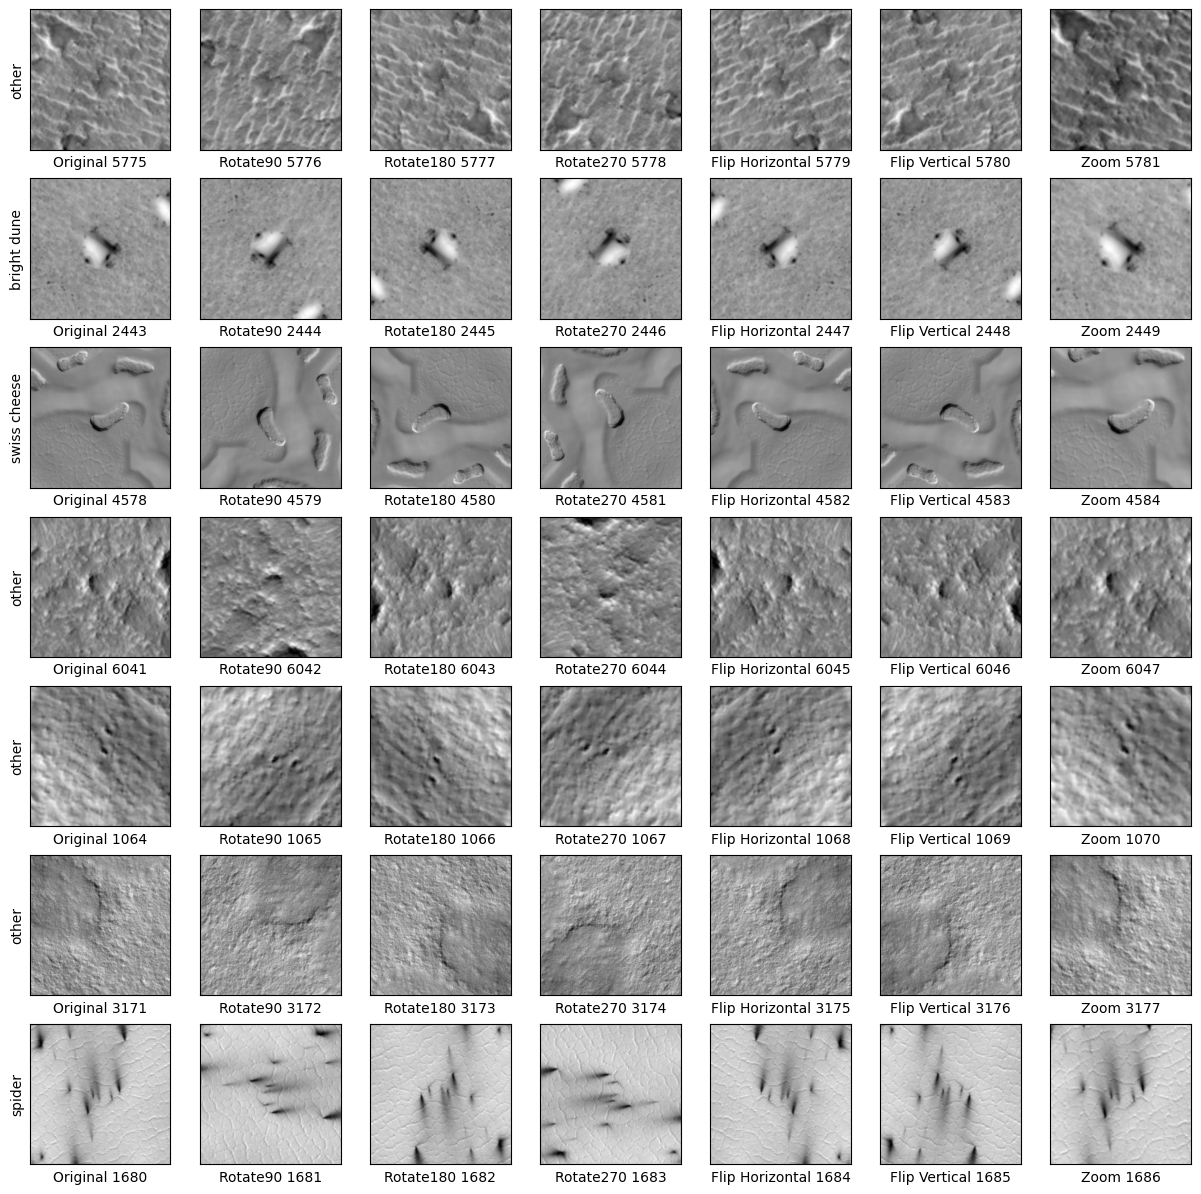

In [211]:
plot_augmented_images(X_t_A_A, y_t_A_A, aug_names, class_names, 7)

# 7. Apply Networks

# 7.1 AlexNet

clear

In [ ]:
keras.backend.clear_session() # clear any previous models

build model

In [ ]:
def create_alex_model():
    # Define your CNN model
    model_alex = keras.models.Sequential([
        keras.layers.Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu') # layer that convolves the input image with 96 different filters that are 11x11 pixels in size
        keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid') # layer that downsamples the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis
        keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu') # layer that convolves the input image with 256 different filters that are 5x5 pixels in size
        keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid') # layer that downsamples the input representation by taking the maximum value over the window defined by pool_size for each dimension along the features axis
        keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu') # layer that convolves the input image with 384 different filters that are 3x3 pixels in size
        keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu') # layer that convolves the input image with 384 different filters that are 3x3 pixels in size
        keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu') # layer that convolves the input image with 384 different filters that are 3x3 pixels in size
        keras.layers.Dense(4096, activation='relu') # layer with 4096 neurons that uses the ReLU activation function and is fully connected
        keras.layers.Dropout(0.5), # layer that randomly sets input units to 0 with a 50% frequency at each step during training time, which helps prevent overfitting
        keras.layers.Dense(4096, activation='relu') # layer with 4096 neurons that uses the ReLU activation function and is fully connected
        keras.layers.Dropout(0.5), # layer that randomly sets input units to 0 with a 50% frequency at each step during training time, which helps prevent overfitting
        keras.layers.Dense(8, activation='softmax') # layer with 8 neurons that uses the softmax activation function to output probabilities for each class
    ])
    return model

random search + training of model

In [ ]:
# sklearn random serach function for a neural network
param_grid = {"optimizer": ["adam", "sgd", "rmsprop"],
              "learning_rate": [0.001, 0.01, 0.1],
              "momentum": [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
              "epochs": [10, 20, 30, 40, 50],
              "batch_size": [10, 20, 30, 40, 50],
              # "activation": ["relu", "sigmoid", "tanh"],
              # "dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
              # "weight_constraint": [1, 2, 3, 4, 5],
              # "neurons": [1, 5, 10, 15, 20, 25, 30]
              }

def random_search(X_train, y_train, X_test, y_test, param_grid, n_iter_search=10, n_jobs=-1, cv=3, verbose=1, random_state=1): 
    # create a random search object
    random_search = RandomizedSearchCV(estimator=KerasClassifier(build_fn=create_alex_model, verbose=0),  # type: ignore
                                        param_distributions=param_grid,
                                        n_iter=n_iter_search,
                                        n_jobs=n_jobs,
                                        cv=cv,
                                        verbose=verbose,
                                        random_state=random_state)
    # fit the random search model
    random_search.fit(X_train, y_train)
    # print results
    print("Best Score: ", random_search.best_score_)
    print("Best Params: ", random_search.best_params_)
    # evaluate the model on test data
    print("Test Accuracy: ", random_search.score(X_test, y_test))
    return random_search

random_search(X_train, y_train, X_test, y_test, param_grid)

# GoogLeNet

In [ ]:
# Import necessary modules
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Dropout, Flatten, concatenate, AveragePooling2D


In [ ]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    path1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(path4)
    return concatenate([path1, path2, path3, path4], axis=-1)

def create_google_model():
    input_layer = Input(shape=(227, 227, 3))

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1000, activation='relu')(x)
    output_layer = Dense(8, activation='softmax')(x)

    # Define the model
    model_googlenet = Model(input_layer, output_layer)

    # Return the model
    return model_googlenet

ChatGPT for application 

In [ ]:
# Create your model
model_google = create_model()

# Compile the model
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = [CategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Fit the model to the training data
log = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model on the test data
model.evaluate(X_test, y_test)

# Use the model to make predictions
predictions = model.predict(X_new)

# If your task is multi-class classification, you can get the class with the highest probability
import numpy as np
class_predictions = np.argmax(predictions, axis=-1)

random search + training the model

In [ ]:
# sklearn random serach function for a neural network
param_grid = {"optimizer": ["adam", "sgd", "rmsprop"],
                "learning_rate": [0.001, 0.01, 0.1],
                "momentum": [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
                "epochs": [10, 20, 30, 40, 50],
                "batch_size": [10, 20, 30, 40, 50],
                "activation": ["relu", "sigmoid", "tanh"],
                "dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                "weight_constraint": [1, 2, 3, 4, 5],
                
                "neurons": [1, 5, 10, 15, 20, 25, 30]}

def random_search(X_train, y_train, X_test, y_test, param_grid, n_iter_search=10, n_jobs=-1, cv=3, verbose=1, random_state=1): 
    # create a random search object
    random_search = RandomizedSearchCV(estimator=KerasClassifier(build_fn=create_google_model, verbose=0), 
                                        param_distributions=param_grid,
                                        n_iter=n_iter_search,
                                        n_jobs=n_jobs,
                                        cv=cv,
                                        verbose=verbose,
                                        random_state=random_state)
    # fit the random search model
    random_search.fit(X_train, y_train)
    # print results
    print("Best Score: ", random_search.best_score_)
    print("Best Params: ", random_search.best_params_)
    # evaluate the model on test data
    print("Test Accuracy: ", random_search.score(X_test, y_test))
    return random_search

random_search(X_train, y_train, X_test, y_test, param_grid)

# ResNet

In [2]:
kein Bock mehr

SyntaxError: invalid syntax (4019976191.py, line 1)